## Capstone Project - Coursera : Part 2

# Where to open an Art Gallery in Brooklyn ? 

Hi, and welcome to my project. As an art lover myself, I can only dream to open a gallery someday, and how about in one of the biggest cities in the world, where museums and galleries are considered premium hot spots ? 

- Description of the problem / background

New York is a huge city, with different boroughs all divided in many neighborhoods. Finding the optimum place where to open an art gallery can be tideous, especially with the outstanding number of them there. Using data science can be a quick way to map the galleries, pick a borough and rapidly cluster their presences. I will be focusing on Brooklyn in this work. 

- Data used 

Two types of data will be used for this project; 
     
     - Data of NY and its different boroughs' coordinates, which was made available on a Coursera Lab  
  
     - Data from Foursquare to know where are situated the art galleries 
     
Linking those two sets of data will allow to map everything accurately. 

- What will we be doing ? 

First, we will prepare and clean our data, then merge both data. We will use the kmeans method to identify the optimal number of clusters to work with, then we will map our results. We will then discuss the best place to open a gallery.

## Moving on to the data preparation

First, let's get some libraries

In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
import requests 
from pandas.io.json import json_normalize

print("import ok")

import ok


Now, let's get the data.

In [3]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
len(neighborhoods['Borough'].unique()),
neighborhoods.shape[0]
    )
     )

The dataframe has 5 boroughs and 306 neighborhoods.


Let's get some more libraries to visualize the data.

In [8]:
!pip install geopy
from geopy.geocoders import Nominatim 

!pip install folium
import folium

print("import ok")

import ok


In [9]:
#defining data coordinates

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of New York City are {}, {}.'.format(latitude, longitude))

The geographical coordinates of New York City are 40.7127281, -74.0060152.


Now let's get our general map of NY 

In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

As we want to focus on Brooklyn, let's clean and refine our data.

In [11]:
brook_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brook_data.head()

Borough Neighborhood   Latitude  Longitude
0  Brooklyn    Bay Ridge  40.625801 -74.030621
1  Brooklyn  Bensonhurst  40.611009 -73.995180
2  Brooklyn  Sunset Park  40.645103 -74.010316
3  Brooklyn   Greenpoint  40.730201 -73.954241
4  Brooklyn    Gravesend  40.595260 -73.973471

In [13]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Brooklyn are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Brooklyn are 40.6501038, -73.9495823.


In [14]:
# create map of Brooklyn using latitude and longitude values
map_brook = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brook_data['Latitude'], brook_data['Longitude'], brook_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brook)  
    
map_brook

Much better ! Now, let's have a look at the venues available

In [15]:
CLIENT_ID = 'XV03ZS242TKYNPF22COZXISGUNOEMN15G55NQBYXUYQYJQCY' # your Foursquare ID
CLIENT_SECRET = 'QGYTQ5GYJ4SLNYTMOJETVPXKEOZQ0ZPYXONZ4KW5BOM4DI1M' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XV03ZS242TKYNPF22COZXISGUNOEMN15G55NQBYXUYQYJQCY
CLIENT_SECRET:QGYTQ5GYJ4SLNYTMOJETVPXKEOZQ0ZPYXONZ4KW5BOM4DI1M


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
brook_venues = getNearbyVenues(names=brook_data['Neighborhood'],
                                latitudes=brook_data['Latitude'],
                                longitudes=brook_data['Longitude'])

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [18]:
brook_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Bay Ridge              40.625801              -74.030621   
1    Bay Ridge              40.625801              -74.030621   
2    Bay Ridge              40.625801              -74.030621   
3    Bay Ridge              40.625801              -74.030621   
4    Bay Ridge              40.625801              -74.030621   

                         Venue  Venue Latitude  Venue Longitude  \
0  Pilo Arts Day Spa and Salon       40.624748       -74.030591   
1                    Bagel Boy       40.627896       -74.029335   
2                 Pegasus Cafe       40.623168       -74.031186   
3          Leo's Casa Calamari       40.624200       -74.030931   
4                Cocoa Grinder       40.623967       -74.030863   

   Venue Category  
0             Spa  
1      Bagel Shop  
2  Breakfast Spot  
3     Pizza Place  
4       Juice Bar

In [19]:
brook_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Bath Beach                                    46                      46   
Bay Ridge                                     81                      81   
Bedford Stuyvesant                            28                      28   
Bensonhurst                                   36                      36   
Bergen Beach                                   7                       7   
Boerum Hill                                   90                      90   
Borough Park                                  22                      22   
Brighton Beach                                43                      43   
Broadway Junction                             20                      20   
Brooklyn Heights                             100                     100   
Brownsville                                   16                      16   
Bushwick                                      70                      70   
Canarsie                                       6                       6   
Carroll Gardens                              100                     100   
City Line                                     33                      33   
Clinton Hill                                  93                      93   
Cobble Hill                                   89                      89   
Coney Island                                  17                      17   
Crown Heights                                 24                      24   
Cypress Hills                                 23                      23   
Ditmas Park                                   51                      51   
Downtown                                     100                     100   
Dumbo                                         68                      68   
Dyker Heights                                  5                       5   
East Flatbush                                 12                      12   
East New York                                 14                      14   
East Williamsburg                             66                      66   
Erasmus                                       24                      24   
Flatbush                                      21                      21   
Flatlands                                     19                      19   
Fort Greene                                   66                      66   
Fort Hamilton                                 70                      70   
Fulton Ferry                                  62                      62   
Georgetown                                    28                      28   
Gerritsen Beach                               18                      18   
Gowanus                                       65                      65   
Gravesend                                     27                      27   
Greenpoint                                   100                     100   
Highland Park                                 13                      13   
Homecrest                                     37                      37   
Kensington                                    36                      36   
Madison                                       11                      11   
Manhattan Beach                                9                       9   
Manhattan Terrace                             27                      27   
Marine Park                                   10                      10   
Midwood                                       13                      13   
Mill Basin                                    34                      34   
Mill Island                                    1                       1   
New Lots                                      25                      25   
North Side                                   100                     100   
Ocean Hill                                    29                      29   

In [20]:
print('There are {} uniques categories.'.format(len(brook_venues['Venue Category'].unique())))
print("The Venue Categories are", brook_venues['Venue Category'].unique())

There are 288 uniques categories.
The Venue Categories are ['Spa' 'Bagel Shop' 'Breakfast Spot' 'Pizza Place' 'Juice Bar'
 'Taco Place' 'Caucasian Restaurant' 'Grocery Store' 'Sports Bar'
 'Middle Eastern Restaurant' 'Hookah Bar' 'Optical Shop' 'Bar' 'Lounge'
 'Bookstore' 'Greek Restaurant' 'Italian Restaurant' 'Chinese Restaurant'
 'Ice Cream Shop' 'Café' 'Tea Room' 'American Restaurant'
 'New American Restaurant' 'Video Game Store' 'Sushi Restaurant'
 'Indian Restaurant' 'Thai Restaurant' 'Seafood Restaurant'
 'Mexican Restaurant' 'Toy / Game Store' 'Department Store'
 'Sandwich Place' 'Vietnamese Restaurant' 'Lingerie Store'
 'Clothing Store' 'Snack Place' 'Gym / Fitness Center' 'Pharmacy'
 'Kids Store' 'Dim Sum Restaurant' 'Fast Food Restaurant' 'Mattress Store'
 'Pool Hall' 'Hotel' 'Supermarket' 'Yoga Studio' 'Boutique'
 'Mediterranean Restaurant' 'Electronics Store' 'Playground' 'Park'
 'Cosmetics Shop' 'Bakery' 'Butcher' 'Shabu-Shabu Restaurant'
 'Noodle House' 'Liquor Store' 'H

In [21]:
"Art Gallery" in brook_venues['Venue Category'].unique()

True

This shows that there is available data on art galleries in Brooklyn. 

In [22]:
# one hot encoding
to_onehot = pd.get_dummies(brook_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = brook_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2766, 289)


Neighborhoods  Accessories Store  American Restaurant  Antique Shop  \
0     Bay Ridge                  0                    0             0   
1     Bay Ridge                  0                    0             0   
2     Bay Ridge                  0                    0             0   
3     Bay Ridge                  0                    0             0   
4     Bay Ridge                  0                    0             0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0                 0                       0            0                    0   
1                 0                       0            0                    0   
2                 0                       0            0                    0   
3                 0                       0            0                    0   
4                 0                       0            0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                     0                 0                   0            0   
1                     0                 0                   0            0   
2                     0                 0                   0            0   
3                     0                 0                   0            0   
4                     0                 0                   0            0   

   BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0          0           0       0     0    0               0                 0   
1          0           1       0     0    0               0                 0   
2          0           0       0     0    0               0                 0   
3          0           0       0     0    0               0                 0   
4          0           0       0     0    0               0                 0   

   Basketball Court  Beach  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                 0      0         0            0           0              0   
1                 0      0         0            0           0              0   
2                 0      0         0            0           0              0   
3                 0      0         0            0           0              0   
4                 0      0         0            0           0              0   

   Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  Boat or Ferry  \
0                         0          0       0           0              0   
1                         0          0       0           0              0   
2                         0          0       0           0              0   
3                         0          0       0           0              0   
4                         0          0       0           0              0   

   Bookstore  Boutique  Boxing Gym  Breakfast Spot  Brewery  Bridge  \
0          0         0           0               0        0       0   
1          0         0           0               0        0       0   
2          0         0           0               1        0       0   
3          0         0           0               0        0       0   
4          0         0           0               0        0       0   

   Bubble Tea Shop  Buffet  Burger Joint  Burmese Restaurant  Burrito Place  \
0                0       0             0                   0              0   
1                0       0             0                   0              0   
2                0       0             0                   0              0   
3                0       0             0                   0              0   
4                0       0             0                   0              0   

   Bus Line  Bus Station  Bus Stop  Business Service  Butcher  Café  \
0         0            0         0                 0        0     0   
1         0            0         0                 0        0     0   
2         0            0         0                 0        0

Now let's isolate data from art galleries

In [24]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(70, 289)


Neighborhoods  Accessories Store  American Restaurant  Antique Shop  \
0          Bath Beach                0.0             0.000000           0.0   
1           Bay Ridge                0.0             0.037037           0.0   
2  Bedford Stuyvesant                0.0             0.000000           0.0   
3         Bensonhurst                0.0             0.000000           0.0   
4        Bergen Beach                0.0             0.000000           0.0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0               0.0                     0.0          0.0                  0.0   
1               0.0                     0.0          0.0                  0.0   
2               0.0                     0.0          0.0                  0.0   
3               0.0                     0.0          0.0                  0.0   
4               0.0                     0.0          0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                   0.0          0.021739            0.000000          0.0   
1                   0.0          0.000000            0.000000          0.0   
2                   0.0          0.000000            0.000000          0.0   
3                   0.0          0.027778            0.000000          0.0   
4                   0.0          0.000000            0.142857          0.0   

   BBQ Joint  Bagel Shop    Bakery      Bank       Bar  Baseball Field  \
0   0.000000    0.021739  0.021739  0.021739  0.000000        0.000000   
1   0.000000    0.024691  0.000000  0.000000  0.037037        0.000000   
2   0.035714    0.035714  0.000000  0.000000  0.071429        0.000000   
3   0.000000    0.027778  0.027778  0.027778  0.027778        0.000000   
4   0.000000    0.000000  0.000000  0.000000  0.000000        0.142857   

   Baseball Stadium  Basketball Court  Beach  Beer Bar  Beer Garden  \
0               0.0               0.0    0.0       0.0          0.0   
1               0.0               0.0    0.0       0.0          0.0   
2               0.0               0.0    0.0       0.0          0.0   
3               0.0               0.0    0.0       0.0          0.0   
4               0.0               0.0    0.0       0.0          0.0   

   Beer Store  Big Box Store  Bike Rental / Bike Share  Bike Shop  Bistro  \
0         0.0            0.0                       0.0        0.0     0.0   
1         0.0            0.0                       0.0        0.0     0.0   
2         0.0            0.0                       0.0        0.0     0.0   
3         0.0            0.0                       0.0        0.0     0.0   
4         0.0            0.0                       0.0        0.0     0.0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Boxing Gym  Breakfast Spot  \
0         0.0            0.0   0.000000  0.000000         0.0        0.000000   
1         0.0            0.0   0.012346  0.012346         0.0        0.012346   
2         0.0            0.0   0.000000  0.035714         0.0        0.000000   
3         0.0            0.0   0.000000  0.000000         0.0        0.000000   
4         0.0            0.0   0.000000  0.000000         0.0        0.000000   

   Brewery  Bridge  Bubble Tea Shop  Buffet  Burger Joint  Burmese Restaurant  \
0      0.0     0.0         0.043478     0.0      0.021739                 0.0   
1      0.0     0.0         0.000000     0.0      0.000000                 0.0   
2      0.0     0.0         0.000000     0.0      0.000000                 0.0   
3      0.0     0.0         0.000000     0.0      0.000000                 0.0   
4      0.0     0.0         0.000000     0.0      0.000000                 0.0   

   Burrito Place  Bus Line  Bus Station  Bus Stop  Business Service   Butcher  \
0            0.0       0.0          0.0  0.000000               0.0  0.000000   
1            0.0       0.0          0.0  0.000000               0.0  0.000000   
2            0.0       0.

In [25]:
artg = to_grouped[["Neighborhoods","Art Gallery"]]
artg = artg.rename(columns={'Neighborhoods':'Neighborhood'})
artg.head() #.head() shows the first five rows only

Neighborhood  Art Gallery
0          Bath Beach          0.0
1           Bay Ridge          0.0
2  Bedford Stuyvesant          0.0
3         Bensonhurst          0.0
4        Bergen Beach          0.0

Now getting into clusters. 

In [27]:
from  sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = artg.drop(['Neighborhood'], axis=1)

In [28]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [29]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [30]:
scores = [get_inertia(x) for x in range(2, 21)]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/

Let's plot some graphs now.

Text(0, 0.5, 'Error')

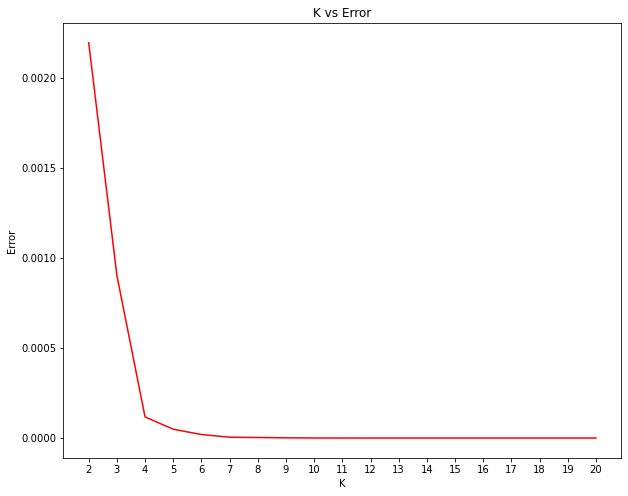

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

This is an import graph because looking at the elbow's curve, which is here =4, we can define the optimum number of clusters to study.

In [32]:
kclusters = 4

brook_grouped_clustering = artg.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brook_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [33]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = artg.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = artg.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

to_merged.head()

Neighborhood  Art Gallery  Cluster Labels
0          Bath Beach          0.0               0
1           Bay Ridge          0.0               0
2  Bedford Stuyvesant          0.0               0
3         Bensonhurst          0.0               0
4        Bergen Beach          0.0               0

In [34]:
# merge datas to add latitude/longitude for each neighborhood
to_merged = to_merged.join(brook_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2766, 9)


Neighborhood  Art Gallery  Cluster Labels  Neighborhood Latitude  \
0   Bath Beach          0.0               0              40.599519   
0   Bath Beach          0.0               0              40.599519   
0   Bath Beach          0.0               0              40.599519   
0   Bath Beach          0.0               0              40.599519   
0   Bath Beach          0.0               0              40.599519   

   Neighborhood Longitude                    Venue  Venue Latitude  \
0              -73.998752  Bay Parkway Water Front       40.595941   
0              -73.998752         Bensonhurst Park       40.597065   
0              -73.998752                Five Guys       40.595236   
0              -73.998752                   Carvel       40.598733   
0              -73.998752       Lutzina Bar&Lounge       40.600807   

   Venue Longitude  Venue Category  
0       -74.000917       Surf Spot  
0       -73.998340            Park  
0       -74.000225    Burger Joint  
0       -73.997670  Ice Cream Shop  
0       -74.000578      Hookah Bar

In [35]:
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

(2766, 9)


Neighborhood  Art Gallery  Cluster Labels  Neighborhood Latitude  \
0    Bath Beach          0.0               0              40.599519   
37   Greenpoint          0.0               0              40.730201   
37   Greenpoint          0.0               0              40.730201   
37   Greenpoint          0.0               0              40.730201   
37   Greenpoint          0.0               0              40.730201   

    Neighborhood Longitude                    Venue  Venue Latitude  \
0               -73.998752  Bay Parkway Water Front       40.595941   
37              -73.954241           Brouwerij Lane       40.729809   
37              -73.954241              Sama Street       40.732702   
37              -73.954241                   Ramona       40.730249   
37              -73.954241               Homecoming       40.729696   

    Venue Longitude Venue Category  
0        -74.000917      Surf Spot  
37       -73.957823     Beer Store  
37       -73.954613   Cocktail Bar  
37       -73.957739   Cocktail Bar  
37       -73.957525    Coffee Shop

In [36]:
to_merged['Venue Category'].value_counts()['Art Gallery']

17

Now we can plot our clusters ! 

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

This map is great because it gives good spatial information on where the clusters are. Now, we need to know which cluster is the most interesting to establish an art gallery in.

Let's get the data from our different clusters in new datasets.

In [38]:
df_new = brook_data[['Borough', 'Neighborhood']]
df_new.head()

Borough Neighborhood
0  Brooklyn    Bay Ridge
1  Brooklyn  Bensonhurst
2  Brooklyn  Sunset Park
3  Brooklyn   Greenpoint
4  Brooklyn    Gravesend

In [39]:
# cluster 1 
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()


Borough Neighborhood  Art Gallery  Cluster Labels  Neighborhood Latitude  \
0  Brooklyn    Bay Ridge          0.0               0              40.625801   
1  Brooklyn    Bay Ridge          0.0               0              40.625801   
2  Brooklyn    Bay Ridge          0.0               0              40.625801   
3  Brooklyn    Bay Ridge          0.0               0              40.625801   
4  Brooklyn    Bay Ridge          0.0               0              40.625801   

   Neighborhood Longitude                               Venue  Venue Latitude  \
0              -74.030621                      Ben's Pizzeria       40.626404   
1              -74.030621  Zitelli's Thin Crust Pizza and Bar       40.623555   
2              -74.030621                     Cappuccino Cafe       40.629510   
3              -74.030621                           Dahn Yoga       40.626273   
4              -74.030621                                Baci       40.624347   

   Venue Longitude       Venue Category  
0       -74.029752          Pizza Place  
1       -74.030969   Italian Restaurant  
2       -74.028539  American Restaurant  
3       -74.030208          Yoga Studio  
4       -74.030761   Italian Restaurant

In [40]:
#cluster 2
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough  Neighborhood  Art Gallery  Cluster Labels  Neighborhood Latitude  \
0  Brooklyn  Williamsburg      0.03125               1              40.707144   
1  Brooklyn  Williamsburg      0.03125               1              40.707144   
2  Brooklyn  Williamsburg      0.03125               1              40.707144   
3  Brooklyn  Williamsburg      0.03125               1              40.707144   
4  Brooklyn  Williamsburg      0.03125               1              40.707144   

   Neighborhood Longitude                    Venue  Venue Latitude  \
0              -73.958115           Roebling Pizza       40.708808   
1              -73.958115                   Weylin       40.710196   
2              -73.958115  Peter Luger Steak House       40.709958   
3              -73.958115               Dough Vale       40.709306   
4              -73.958115           Silver Factory       40.709318   

   Venue Longitude      Venue Category  
0       -73.960901         Pizza Place  
1       -73.962318         Event Space  
2       -73.962291          Steakhouse  
3       -73.954056  Italian Restaurant  
4       -73.958536              Lounge

In [41]:
#cluster 3 
cluster3=to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough Neighborhood  Art Gallery  Cluster Labels  Neighborhood Latitude  \
0  Brooklyn     Red Hook     0.061224               2              40.676253   
1  Brooklyn     Red Hook     0.061224               2              40.676253   
2  Brooklyn     Red Hook     0.061224               2              40.676253   
3  Brooklyn     Red Hook     0.061224               2              40.676253   
4  Brooklyn     Red Hook     0.061224               2              40.676253   

   Neighborhood Longitude                    Venue  Venue Latitude  \
0              -74.012759     Ample Hills Creamery       40.674959   
1              -74.012759  Dry Dock Wine & Spirits       40.675743   
2              -74.012759          Red Hook Tavern       40.677836   
3              -74.012759                    Baked       40.676959   
4              -74.012759               Somtum Der       40.677070   

   Venue Longitude   Venue Category  
0       -74.015526   Ice Cream Shop  
1       -74.014805        Wine Shop  
2       -74.012036              Bar  
3       -74.013327           Bakery  
4       -74.013306  Thai Restaurant

In [42]:
#cluster 4
cluster4=to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough Neighborhood  Art Gallery  Cluster Labels  Neighborhood Latitude  \
0  Brooklyn     Bushwick     0.014286               3              40.698116   
1  Brooklyn     Bushwick     0.014286               3              40.698116   
2  Brooklyn     Bushwick     0.014286               3              40.698116   
3  Brooklyn     Bushwick     0.014286               3              40.698116   
4  Brooklyn     Bushwick     0.014286               3              40.698116   

   Neighborhood Longitude                      Venue  Venue Latitude  \
0              -73.925258         Mr. Deli and Grill       40.695101   
1              -73.925258            Bushwick Bakery       40.699976   
2              -73.925258                Dollar Tree       40.698209   
3              -73.925258  Zefe's Mexican Restaurant       40.697641   
4              -73.925258                    NYC Pet       40.701410   

   Venue Longitude      Venue Category  
0       -73.928742       Deli / Bodega  
1       -73.927982              Bakery  
2       -73.923327      Discount Store  
3       -73.929169  Mexican Restaurant  
4       -73.922901           Pet Store

Now let's look into the mean Art Gallery presence.

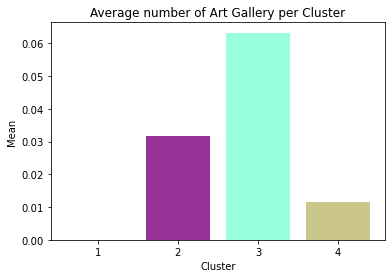

In [43]:
clusters_mean = [df_cluster1['Art Gallery'].mean(),df_cluster2['Art Gallery'].mean(),df_cluster3['Art Gallery'].mean(),
                 df_cluster4['Art Gallery'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Art Gallery per Cluster')

plt.show()

As you can see, the cluster 3 corresponds to the biggest amount of art galleries in brooklyn. Looking on the map, it corresponds to only a few locations. 


## Conclusion

Brooklyn is a spot in which opening galleries could be interesting. One cluster emerges as a key spot for such openings, it is cluster n3. Although, cluster n2 can also be interesting, as it is suituated in cheapest (rent wise) areas. Now, other criterias must be looked upon, such as rent, available space ans accessibility before investing  ! 

Thank you for taking the time to read and correct my work